# Methodology
We will perform a two-tail, two-sample t-test on the data. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Question

Is a significant difference in the percentage of A's given based on whether a class starts before noon or after noon. 

## Hypotheses
We select an alpha value of 0.05.

Null Hypothesis: There is no significant difference in the mean percentage of A's in the morning classes and afternoon classes.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's in the morning and afternoon classes.

Class start and end time is listed in minutes from midnight.

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [4]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
0,0,0,0,0,0,0,0,-1,FLD,eb6254ad-776c-3830-9a85-0684665c1457,14,0
1,0,0,0,0,0,0,0,-1,FLD,94d362f0-53b2-33d0-85ca-4770d1371c97,10,0
2,35,0,1,0,0,0,0,960,LAB,e1a0631e-6efc-3021-a20d-a4a92081b754,1,36
3,39,1,0,1,0,0,0,725,LAB,c939dd5e-43ba-3266-8f74-573f629de75b,4,41
4,32,2,1,1,0,0,0,595,LAB,5c0652d8-d118-3652-8cbe-16b4a589aa03,2,36


In [5]:
df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
0,0,0,0,0,0,0,0,-1,FLD,eb6254ad-776c-3830-9a85-0684665c1457,14,0
118439,0,0,0,0,0,0,0,-1,IND,872a8a2c-dcac-37cb-8a7a-be16263167be,10,0
118438,0,0,0,0,0,0,0,-1,IND,4a76637f-e031-3cd2-98bd-ab6e9095577b,27,0
118437,0,0,0,0,0,0,0,-1,IND,4a76637f-e031-3cd2-98bd-ab6e9095577b,38,0
118436,0,0,0,0,0,0,0,-1,IND,4a76637f-e031-3cd2-98bd-ab6e9095577b,87,0


In [6]:
df.loc[df['start_time'] == -1, 'section_type'].value_counts()

IND    81726
LEC     4405
FLD     3691
SEM     1344
LAB     1331
DIS       19
Name: section_type, dtype: int64

In [7]:
df.loc[df['section_type'] == 'IND', 'section_type'].value_counts()

IND    81726
Name: section_type, dtype: int64

All the independent studies are -1. As all these values are no use to our test (because we are interested in start time) we will drop all start_times of -1. We will also cut of irregular times (classes that start before 6AM) because these are potentially errors during input.

In [8]:
df = df[df['start_time'] >= 360]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124879 entries, 2 to 217338
Data columns (total 12 columns):
a_count                 124879 non-null int64
ab_count                124879 non-null int64
b_count                 124879 non-null int64
bc_count                124879 non-null int64
c_count                 124879 non-null int64
d_count                 124879 non-null int64
f_count                 124879 non-null int64
start_time              124879 non-null int64
section_type            124879 non-null object
course_offering_uuid    124879 non-null object
section_number          124879 non-null int64
total_count             124879 non-null int64
dtypes: int64(10), object(2)
memory usage: 12.4+ MB


In [9]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,section_type,course_offering_uuid,section_number,total_count
106076,0,0,0,0,0,0,0,660,LEC,4ec6a03d-540d-39e9-a423-e89863b12b97,2,0
166772,0,0,0,0,0,0,0,660,SEM,9e759bca-90a7-3e66-be6f-31e0be2a4524,1,0
166773,0,0,0,0,0,0,0,660,SEM,d4282d2d-0325-3843-832a-d4b3293e1e5a,1,0
166774,0,0,0,0,0,0,0,660,SEM,d4282d2d-0325-3843-832a-d4b3293e1e5a,1,0
166783,0,0,0,0,0,0,0,870,LEC,7baf7e06-670c-377c-bd69-2ad80c469a02,1,0


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [10]:
df = df[df['total_count'] != 0]

In [11]:
df['total_count'].value_counts().head()

13    3792
12    3661
15    3594
10    3574
19    3546
Name: total_count, dtype: int64

In [12]:
df2 = df.copy()

In [13]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101089 entries, 2 to 217338
Data columns (total 13 columns):
a_count                 101089 non-null int64
ab_count                101089 non-null int64
b_count                 101089 non-null int64
bc_count                101089 non-null int64
c_count                 101089 non-null int64
d_count                 101089 non-null int64
f_count                 101089 non-null int64
start_time              101089 non-null int64
section_type            101089 non-null object
course_offering_uuid    101089 non-null object
section_number          101089 non-null int64
total_count             101089 non-null int64
ratio_of_as             101089 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 10.8+ MB


/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


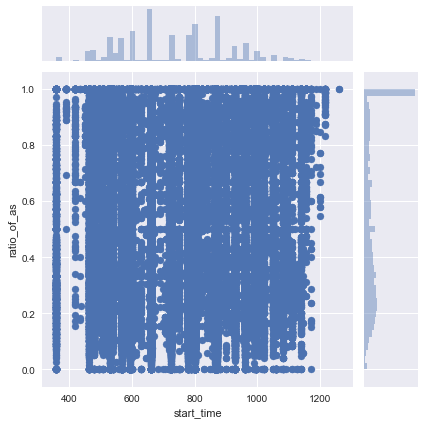

In [15]:
sns.jointplot('start_time', 'ratio_of_as',df2)

In [16]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81715 entries, 2 to 217338
Data columns (total 13 columns):
a_count                 81715 non-null int64
ab_count                81715 non-null int64
b_count                 81715 non-null int64
bc_count                81715 non-null int64
c_count                 81715 non-null int64
d_count                 81715 non-null int64
f_count                 81715 non-null int64
start_time              81715 non-null int64
section_type            81715 non-null object
course_offering_uuid    81715 non-null object
section_number          81715 non-null int64
total_count             81715 non-null int64
ratio_of_as             81715 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 8.7+ MB


/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


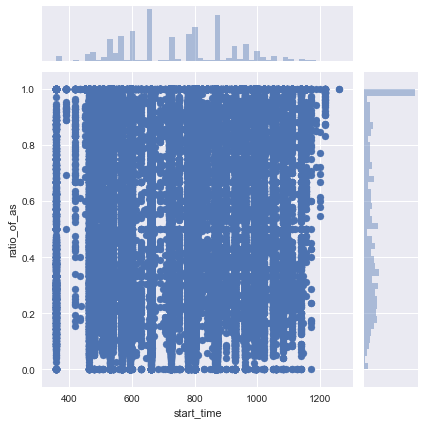

In [17]:
sns.jointplot('start_time', 'ratio_of_as',df2)

In [18]:
df2['section_type'].value_counts()

LEC    62645
LAB     8476
SEM     8342
FLD     1965
DIS      287
Name: section_type, dtype: int64

In [19]:
morning_df = df2.loc[df['start_time'] < 720]
afternoon_df = df2.loc[df['start_time'] >= 720]

In [20]:
morning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36770 entries, 4 to 217332
Data columns (total 13 columns):
a_count                 36770 non-null int64
ab_count                36770 non-null int64
b_count                 36770 non-null int64
bc_count                36770 non-null int64
c_count                 36770 non-null int64
d_count                 36770 non-null int64
f_count                 36770 non-null int64
start_time              36770 non-null int64
section_type            36770 non-null object
course_offering_uuid    36770 non-null object
section_number          36770 non-null int64
total_count             36770 non-null int64
ratio_of_as             36770 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 3.9+ MB


In [21]:
afternoon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44945 entries, 2 to 217338
Data columns (total 13 columns):
a_count                 44945 non-null int64
ab_count                44945 non-null int64
b_count                 44945 non-null int64
bc_count                44945 non-null int64
c_count                 44945 non-null int64
d_count                 44945 non-null int64
f_count                 44945 non-null int64
start_time              44945 non-null int64
section_type            44945 non-null object
course_offering_uuid    44945 non-null object
section_number          44945 non-null int64
total_count             44945 non-null int64
ratio_of_as             44945 non-null float64
dtypes: float64(1), int64(10), object(2)
memory usage: 4.8+ MB


/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


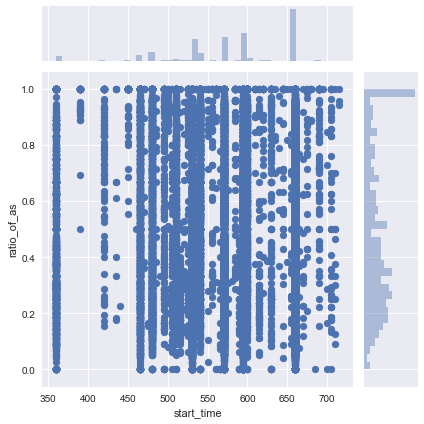

In [22]:
sns.jointplot('start_time', 'ratio_of_as',morning_df)

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


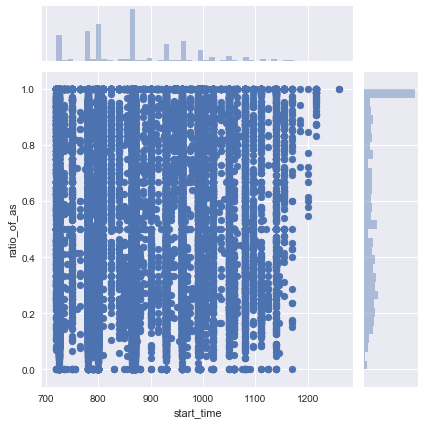

In [23]:
sns.jointplot('start_time', 'ratio_of_as',afternoon_df)

# Determine Sample Size

In [26]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
morn_var = np.var(morning_df['ratio_of_as'])
morn_n = len(morning_df['ratio_of_as'])
aft_var = np.var(afternoon_df['ratio_of_as'])
aft_n = len(afternoon_df['ratio_of_as'])

num = (morn_n - 1) * morn_var + (aft_n - 1) * aft_var
den = morn_n + aft_n - 2
pooled_std = np.sqrt(num/den)

In [27]:
n = 2 * (z * pooled_std / moe)**2
n

67.22208319094825

We will use samples from morning and afternoon of size 68.

In [28]:
morning = morning_df['ratio_of_as']
afternoon = afternoon_df['ratio_of_as']

morning_sample = np.random.choice(morning, size=68)
afternoon_sample = np.random.choice(afternoon, size=68)

In [29]:
stats.ttest_ind(morning_sample, afternoon_sample)

Ttest_indResult(statistic=-1.5342691611147814, pvalue=0.12732115870135186)

Our p-value is about 0.127 which is greater than our alpha of 0.05. This means that we cannot reject the null hypothesis. We cannot say that there is a statistical difference in the ratio of A's of a class depending on if the class is before or after noon. 

If we want to improve our schedules to increase the percentage of A's we will need to look at other factors.